In [2]:
# Requisitos
# IMPORTANTE: En Windows Utilizar Python de 3.6 a 3.9, es requisito de tensorflow
# https://graphviz.gitlab.io/download/
!pip install pydot
!pip install pandas
!pip install tensorflow

##### Copyright 2019 The TensorFlow Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [3]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Load a pandas DataFrame

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/load_data/pandas_dataframe"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/load_data/pandas_dataframe.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/load_data/pandas_dataframe.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/load_data/pandas_dataframe.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial provides examples of how to load <a href="https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html" class="external">pandas DataFrames</a> into TensorFlow.

You will use a small <a href="https://archive.ics.uci.edu/ml/datasets/heart+Disease" class="external">heart disease dataset</a> provided by the UCI Machine Learning Repository. There are several hundred rows in the CSV. Each row describes a patient, and each column describes an attribute. You will use this information to predict whether a patient has heart disease, which is a binary classification task.

## Read data using pandas

In [4]:
import pandas as pd
import tensorflow as tf

SHUFFLE_BUFFER = 500
BATCH_SIZE = 2

Download the CSV file containing the heart disease dataset:

In [5]:
csv_file = tf.keras.utils.get_file('heart.csv', 'https://storage.googleapis.com/download.tensorflow.org/data/heart.csv')

Read the CSV file using pandas:

In [6]:
df = pd.read_csv(csv_file)

This is what the data looks like:

In [54]:
df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,63,1,1,145,233,1,2,150,0,2.3,3,0,fixed
1,67,1,4,160,286,0,2,108,1,1.5,2,3,normal
2,67,1,4,120,229,0,2,129,1,2.6,2,2,reversible
3,37,1,3,130,250,0,0,187,0,3.5,3,0,normal
4,41,0,2,130,204,0,2,172,0,1.4,1,0,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,52,1,1,118,186,0,2,190,0,0.0,2,0,fixed
299,43,0,4,132,341,1,2,136,1,3.0,2,0,reversible
300,65,1,4,135,254,0,2,127,0,2.8,2,1,reversible
301,48,1,4,130,256,1,2,150,1,0.0,1,2,reversible


In [8]:
df.dtypes

age           int64
sex           int64
cp            int64
trestbps      int64
chol          int64
fbs           int64
restecg       int64
thalach       int64
exang         int64
oldpeak     float64
slope         int64
ca            int64
thal         object
target        int64
dtype: object

You will build models to predict the label contained in the `target` column.

In [9]:
target = df.pop('target')

## A DataFrame as an array

If your data has a uniform datatype, or `dtype`, it's possible to use a pandas DataFrame anywhere you could use a NumPy array. This works because the `pandas.DataFrame` class supports the `__array__` protocol, and TensorFlow's `tf.convert_to_tensor` function accepts objects that support the protocol.

Take the numeric features from the dataset (skip the categorical features for now):

In [10]:
numeric_feature_names = ['age', 'thalach', 'trestbps',  'chol', 'oldpeak']
numeric_features = df[numeric_feature_names]
numeric_features.head()

,age,thalach,trestbps,chol,oldpeak
0,63,150,145,233,2.3
1,67,108,160,286,1.5
2,67,129,120,229,2.6
3,37,187,130,250,3.5
4,41,172,130,204,1.4


The DataFrame can be converted to a NumPy array using the `DataFrame.values` property or `numpy.array(df)`. To convert it to a tensor, use `tf.convert_to_tensor`:

In [11]:
tf.convert_to_tensor(numeric_features)

<tf.Tensor: shape=(303, 5), dtype=float64, numpy=
array([[ 63. , 150. , 145. , 233. ,   2.3],
       [ 67. , 108. , 160. , 286. ,   1.5],
       [ 67. , 129. , 120. , 229. ,   2.6],
       ...,
       [ 65. , 127. , 135. , 254. ,   2.8],
       [ 48. , 150. , 130. , 256. ,   0. ],
       [ 63. , 154. , 150. , 407. ,   4. ]])>

In general, if an object can be converted to a tensor with `tf.convert_to_tensor` it can be passed anywhere you can pass a `tf.Tensor`.

### With Model.fit

A DataFrame, interpreted as a single tensor, can be used directly as an argument to the `Model.fit` method.

Below is an example of training a model on the numeric features of the dataset.

The first step is to normalize the input ranges. Use a `tf.keras.layers.Normalization` layer for that.

To set the layer's mean and standard-deviation before running it be sure to call the `Normalization.adapt` method:

In [12]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(numeric_features)

Call the layer on the first three rows of the DataFrame to visualize an example of the output from this layer:

In [13]:
normalizer(numeric_features.iloc[:3])

<tf.Tensor: shape=(3, 5), dtype=float32, numpy=
array([[ 0.93383914,  0.03480718,  0.74578077, -0.26008666,  1.0680453 ],
       [ 1.3782105 , -1.7806165 ,  1.5923285 ,  0.7573878 ,  0.38022864],
       [ 1.3782105 , -0.87290466, -0.6651321 , -0.3368772 ,  1.3259765 ]],
      dtype=float32)>

Use the normalization layer as the first layer of a simple model:

In [14]:
def get_basic_model():
  model = tf.keras.Sequential([
    normalizer,
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1)
  ])

  model.compile(optimizer='adam',
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=['accuracy'])
  return model

When you pass the DataFrame as the `x` argument to `Model.fit`, Keras treats the DataFrame as it would a NumPy array:

In [15]:
model = get_basic_model()
model.fit(numeric_features, target, epochs=15, batch_size=BATCH_SIZE)

Epoch 1/15


152/152 [==============================] - 0s 655us/step - loss: 0.6134 - accuracy: 0.7261
Epoch 2/15
152/152 [==============================] - 0s 724us/step - loss: 0.5205 - accuracy: 0.7459
Epoch 3/15
152/152 [==============================] - 0s 587us/step - loss: 0.4810 - accuracy: 0.7492
Epoch 4/15
152/152 [==============================] - 0s 611us/step - loss: 0.4597 - accuracy: 0.7690
Epoch 5/15
152/152 [==============================] - 0s 583us/step - loss: 0.4453 - accuracy: 0.7624
Epoch 6/15
152/152 [==============================] - 0s 621us/step - loss: 0.4376 - accuracy: 0.7822
Epoch 7/15
152/152 [==============================] - 0s 652us/step - loss: 0.4311 - accuracy: 0.7789
Epoch 8/15
152/152 [==============================] - 0s 517us/step - loss: 0.4273 - accuracy: 0.7855
Epoch 9/15
152/152 [==============================] - 0s 623us/step - loss: 0.4242 - accuracy: 0.7822
Epoch 10/15
152/152 [==============================] - 0s 621us/step - loss: 0.4217 - accurac

### With tf.data

If you want to apply `tf.data` transformations to a DataFrame of a uniform `dtype`, the `Dataset.from_tensor_slices` method will create a dataset that iterates over the rows of the DataFrame. Each row is initially a vector of values. To train a model, you need `(inputs, labels)` pairs, so pass `(features, labels)` and `Dataset.from_tensor_slices` will return the needed pairs of slices:

In [16]:
numeric_dataset = tf.data.Dataset.from_tensor_slices((numeric_features, target))

for row in numeric_dataset.take(3):
  print(row)

(<tf.Tensor: shape=(5,), dtype=float64, numpy=array([ 63. , 150. , 145. , 233. ,   2.3])>, <tf.Tensor: shape=(), dtype=int64, numpy=0>)
(<tf.Tensor: shape=(5,), dtype=float64, numpy=array([ 67. , 108. , 160. , 286. ,   1.5])>, <tf.Tensor: shape=(), dtype=int64, numpy=1>)
(<tf.Tensor: shape=(5,), dtype=float64, numpy=array([ 67. , 129. , 120. , 229. ,   2.6])>, <tf.Tensor: shape=(), dtype=int64, numpy=0>)


In [17]:
numeric_batches = numeric_dataset.shuffle(1000).batch(BATCH_SIZE)

model = get_basic_model()
model.fit(numeric_batches, epochs=15)

Epoch 1/15


152/152 [==============================] - 0s 643us/step - loss: 0.6554 - accuracy: 0.7261
Epoch 2/15
152/152 [==============================] - 0s 623us/step - loss: 0.5516 - accuracy: 0.7261
Epoch 3/15
152/152 [==============================] - 0s 621us/step - loss: 0.4835 - accuracy: 0.7294
Epoch 4/15
152/152 [==============================] - 0s 626us/step - loss: 0.4544 - accuracy: 0.7393
Epoch 5/15
152/152 [==============================] - 0s 621us/step - loss: 0.4429 - accuracy: 0.7525
Epoch 6/15
152/152 [==============================] - 0s 621us/step - loss: 0.4340 - accuracy: 0.7756
Epoch 7/15
152/152 [==============================] - 0s 517us/step - loss: 0.4301 - accuracy: 0.7822
Epoch 8/15
152/152 [==============================] - 0s 517us/step - loss: 0.4275 - accuracy: 0.7789
Epoch 9/15
152/152 [==============================] - 0s 517us/step - loss: 0.4259 - accuracy: 0.7822
Epoch 10/15
152/152 [==============================] - 0s 593us/step - loss: 0.4228 - accurac

## A DataFrame as a dictionary

When you start dealing with heterogeneous data, it is no longer possible to treat the DataFrame as if it were a single array. TensorFlow tensors require that all elements have the same `dtype`.

So, in this case, you need to start treating it as a dictionary of columns, where each column has a uniform `dtype`. A DataFrame is a lot like a dictionary of arrays, so typically all you need to do is cast the DataFrame to a Python dict. Many important TensorFlow APIs support (nested-)dictionaries of arrays as inputs.

`tf.data` input pipelines handle this quite well. All `tf.data` operations handle dictionaries and tuples automatically. So, to make a dataset of dictionary-examples from a DataFrame, just cast it to a dict before slicing it with `Dataset.from_tensor_slices`:

In [18]:
numeric_dict_ds = tf.data.Dataset.from_tensor_slices((dict(numeric_features), target))

Here are the first three examples from that dataset:

In [19]:
for row in numeric_dict_ds.take(3):
  print(row)

({'age': <tf.Tensor: shape=(), dtype=int64, numpy=63>, 'thalach': <tf.Tensor: shape=(), dtype=int64, numpy=150>, 'trestbps': <tf.Tensor: shape=(), dtype=int64, numpy=145>, 'chol': <tf.Tensor: shape=(), dtype=int64, numpy=233>, 'oldpeak': <tf.Tensor: shape=(), dtype=float64, numpy=2.3>}, <tf.Tensor: shape=(), dtype=int64, numpy=0>)
({'age': <tf.Tensor: shape=(), dtype=int64, numpy=67>, 'thalach': <tf.Tensor: shape=(), dtype=int64, numpy=108>, 'trestbps': <tf.Tensor: shape=(), dtype=int64, numpy=160>, 'chol': <tf.Tensor: shape=(), dtype=int64, numpy=286>, 'oldpeak': <tf.Tensor: shape=(), dtype=float64, numpy=1.5>}, <tf.Tensor: shape=(), dtype=int64, numpy=1>)
({'age': <tf.Tensor: shape=(), dtype=int64, numpy=67>, 'thalach': <tf.Tensor: shape=(), dtype=int64, numpy=129>, 'trestbps': <tf.Tensor: shape=(), dtype=int64, numpy=120>, 'chol': <tf.Tensor: shape=(), dtype=int64, numpy=229>, 'oldpeak': <tf.Tensor: shape=(), dtype=float64, numpy=2.6>}, <tf.Tensor: shape=(), dtype=int64, numpy=0>)


### Dictionaries with Keras

Typically, Keras models and layers expect a single input tensor, but these classes can accept and return nested structures of dictionaries, tuples and tensors. These structures are known as "nests" (refer to the `tf.nest` module for details).

There are two equivalent ways you can write a Keras model that accepts a dictionary as input.

#### 1. The Model-subclass style

You write a subclass of `tf.keras.Model` (or `tf.keras.Layer`). You directly handle the inputs, and create the outputs:

In [20]:
def stack_dict(inputs, fun=tf.stack):
  values = []
  for key in sorted(inputs.keys()):
    values.append(tf.cast(inputs[key], tf.float32))
  return fun(values, axis=-1)

In [21]:
#@title
class MyModel(tf.keras.Model):
  def __init__(self):
    # Create all the internal layers in init.
    super().__init__()

    self.normalizer = tf.keras.layers.Normalization(axis=-1)

    self.seq = tf.keras.Sequential([
      self.normalizer,
      tf.keras.layers.Dense(10, activation='relu'),
      tf.keras.layers.Dense(10, activation='relu'),
      tf.keras.layers.Dense(1)
    ])

  def adapt(self, inputs):
    # Stack the inputs and `adapt` the normalization layer.
    inputs = stack_dict(inputs)
    self.normalizer.adapt(inputs)

  def call(self, inputs):
    # Stack the inputs
    inputs = stack_dict(inputs)
    # Run them through all the layers.
    result = self.seq(inputs)

    return result

model = MyModel()

model.adapt(dict(numeric_features))

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'],
              run_eagerly=True)

This model can accept either a dictionary of columns or a dataset of dictionary-elements for training:

In [22]:
model.fit(dict(numeric_features), target, epochs=5, batch_size=BATCH_SIZE)

Epoch 1/5
152/152 [==============================] - 2s 12ms/step - loss: 0.6011 - accuracy: 0.7294
Epoch 2/5
152/152 [==============================] - 2s 12ms/step - loss: 0.5030 - accuracy: 0.7294
Epoch 3/5
152/152 [==============================] - 2s 11ms/step - loss: 0.4667 - accuracy: 0.7360
Epoch 4/5
152/152 [==============================] - 2s 12ms/step - loss: 0.4511 - accuracy: 0.7426
Epoch 5/5
152/152 [==============================] - 2s 11ms/step - loss: 0.4414 - accuracy: 0.7558


In [23]:
numeric_dict_batches = numeric_dict_ds.shuffle(SHUFFLE_BUFFER).batch(BATCH_SIZE)
model.fit(numeric_dict_batches, epochs=5)

Epoch 1/5
  1/152 [..............................] - ETA: 2s - loss: 0.2190 - accuracy: 1.0000

152/152 [==============================] - 2s 10ms/step - loss: 0.4362 - accuracy: 0.7657
Epoch 2/5
152/152 [==============================] - 2s 11ms/step - loss: 0.4341 - accuracy: 0.7690
Epoch 3/5
152/152 [==============================] - 2s 10ms/step - loss: 0.4299 - accuracy: 0.7822
Epoch 4/5
152/152 [==============================] - 2s 10ms/step - loss: 0.4280 - accuracy: 0.7888
Epoch 5/5
152/152 [==============================] - 2s 10ms/step - loss: 0.4251 - accuracy: 0.7921


Here are the predictions for the first three examples:

In [24]:
model.predict(dict(numeric_features.iloc[:3]))

1/1 [==============================] - 0s 16ms/step


array([[[0.01930612]],

       [[0.36060554]],

       [[0.3800438 ]]], dtype=float32)

#### 2. The Keras functional style

In [25]:
inputs = {}
for name, column in numeric_features.items():
  inputs[name] = tf.keras.Input(
      shape=(1,), name=name, dtype=tf.float32)

inputs

{'age': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'age')>,
 'thalach': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'thalach')>,
 'trestbps': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'trestbps')>,
 'chol': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'chol')>,
 'oldpeak': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'oldpeak')>}

In [26]:
x = stack_dict(inputs, fun=tf.concat)

normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(stack_dict(dict(numeric_features)))

x = normalizer(x)
x = tf.keras.layers.Dense(10, activation='relu')(x)
x = tf.keras.layers.Dense(10, activation='relu')(x)
x = tf.keras.layers.Dense(1)(x)

model = tf.keras.Model(inputs, x)

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'],
              run_eagerly=True)

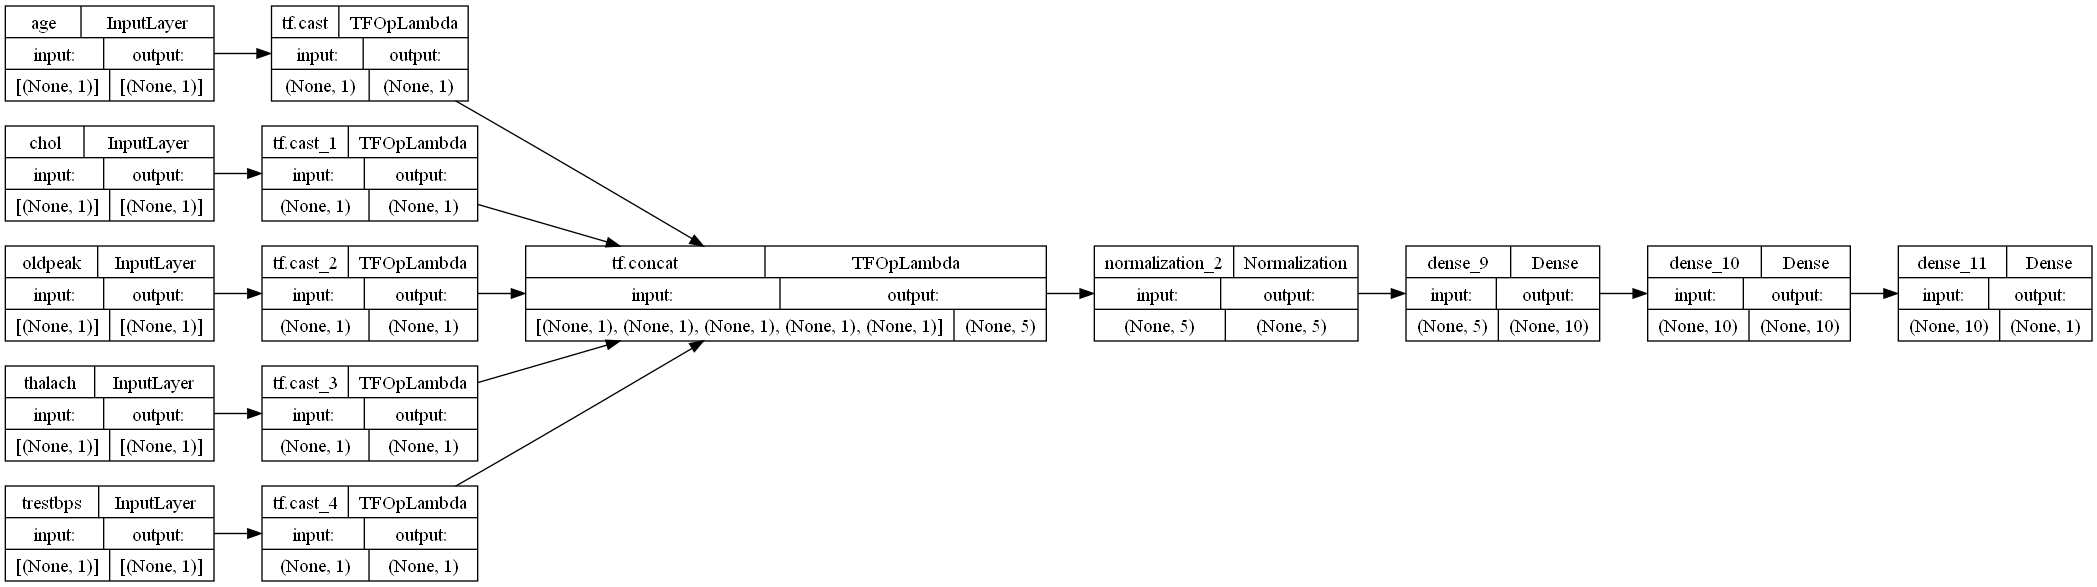

In [27]:
tf.keras.utils.plot_model(model, rankdir="LR", show_shapes=True)

You can train the functional model the same way as the model subclass:

In [28]:
model.fit(dict(numeric_features), target, epochs=5, batch_size=BATCH_SIZE)

Epoch 1/5


152/152 [==============================] - 2s 11ms/step - loss: 0.6897 - accuracy: 0.7261
Epoch 2/5
152/152 [==============================] - 2s 11ms/step - loss: 0.6026 - accuracy: 0.7261
Epoch 3/5
152/152 [==============================] - 2s 11ms/step - loss: 0.5327 - accuracy: 0.7261
Epoch 4/5
152/152 [==============================] - 2s 11ms/step - loss: 0.4973 - accuracy: 0.7261
Epoch 5/5
152/152 [==============================] - 2s 11ms/step - loss: 0.4782 - accuracy: 0.7261


In [29]:
numeric_dict_batches = numeric_dict_ds.shuffle(SHUFFLE_BUFFER).batch(BATCH_SIZE)
model.fit(numeric_dict_batches, epochs=5)

Epoch 1/5
152/152 [==============================] - 2s 11ms/step - loss: 0.4678 - accuracy: 0.7261
Epoch 2/5
152/152 [==============================] - 2s 11ms/step - loss: 0.4607 - accuracy: 0.7261
Epoch 3/5
152/152 [==============================] - 2s 11ms/step - loss: 0.4546 - accuracy: 0.7393
Epoch 4/5
152/152 [==============================] - 2s 11ms/step - loss: 0.4501 - accuracy: 0.7492
Epoch 5/5
152/152 [==============================] - 2s 11ms/step - loss: 0.4457 - accuracy: 0.7558


## Full example

If you're passing a heterogeneous DataFrame to Keras, each column may need unique preprocessing. You could do this preprocessing directly in the DataFrame, but for a model to work correctly, inputs always need to be preprocessed the same way. So, the best approach is to build the preprocessing into the model. [Keras preprocessing layers](https://www.tensorflow.org/guide/keras/preprocessing_layers) cover many common tasks.

### Build the preprocessing head

In this dataset some of the "integer" features in the raw data are actually Categorical indices. These indices are not really ordered numeric values (refer to the <a href="https://archive.ics.uci.edu/ml/datasets/heart+Disease" class="external">the dataset description</a> for details). Because these are unordered they are inappropriate to feed directly to the model; the model would interpret them as being ordered. To use these inputs you'll need to encode them, either as one-hot vectors or embedding vectors. The same applies to string-categorical features.

Note: If you have many features that need identical preprocessing it's more efficient to concatenate them together before applying the preprocessing.

Binary features on the other hand do not generally need to be encoded or normalized.

Start by by creating a list of the features that fall into each group:

In [30]:
binary_feature_names = ['sex', 'fbs', 'exang']

In [31]:
categorical_feature_names = ['cp', 'restecg', 'slope', 'thal', 'ca']

The next step is to build a preprocessing model that will apply appropriate preprocessing to each input and concatenate the results.

This section uses the [Keras Functional API](https://www.tensorflow.org/guide/keras/functional) to implement  the preprocessing. You start by creating one `tf.keras.Input` for each column of the dataframe:

In [32]:
inputs = {}
for name, column in df.items():
  if type(column[0]) == str:
    dtype = tf.string
  elif (name in categorical_feature_names or
        name in binary_feature_names):
    dtype = tf.int64
  else:
    dtype = tf.float32

  inputs[name] = tf.keras.Input(shape=(), name=name, dtype=dtype)

In [33]:
inputs

{'age': <KerasTensor: shape=(None,) dtype=float32 (created by layer 'age')>,
 'sex': <KerasTensor: shape=(None,) dtype=int64 (created by layer 'sex')>,
 'cp': <KerasTensor: shape=(None,) dtype=int64 (created by layer 'cp')>,
 'trestbps': <KerasTensor: shape=(None,) dtype=float32 (created by layer 'trestbps')>,
 'chol': <KerasTensor: shape=(None,) dtype=float32 (created by layer 'chol')>,
 'fbs': <KerasTensor: shape=(None,) dtype=int64 (created by layer 'fbs')>,
 'restecg': <KerasTensor: shape=(None,) dtype=int64 (created by layer 'restecg')>,
 'thalach': <KerasTensor: shape=(None,) dtype=float32 (created by layer 'thalach')>,
 'exang': <KerasTensor: shape=(None,) dtype=int64 (created by layer 'exang')>,
 'oldpeak': <KerasTensor: shape=(None,) dtype=float32 (created by layer 'oldpeak')>,
 'slope': <KerasTensor: shape=(None,) dtype=int64 (created by layer 'slope')>,
 'ca': <KerasTensor: shape=(None,) dtype=int64 (created by layer 'ca')>,
 'thal': <KerasTensor: shape=(None,) dtype=string 

For each input you'll apply some transformations using Keras layers and TensorFlow ops. Each feature starts as a batch of scalars (`shape=(batch,)`). The output for each  should be a batch of `tf.float32` vectors (`shape=(batch, n)`). The last step will concatenate all those vectors together.


#### Binary inputs

Since the binary inputs don't need any preprocessing, just add the vector axis, cast them to `float32` and add them to the list of preprocessed inputs:

In [34]:
preprocessed = []

for name in binary_feature_names:
  inp = inputs[name]
  inp = inp[:, tf.newaxis]
  float_value = tf.cast(inp, tf.float32)
  preprocessed.append(float_value)

preprocessed

[<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'tf.cast_5')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'tf.cast_6')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'tf.cast_7')>]

#### Numeric inputs

Like in the earlier section you'll want to run these numeric inputs through a `tf.keras.layers.Normalization` layer before using them. The difference is that this time they're input as a dict. The code below collects the numeric features from the DataFrame, stacks them together and passes those to the `Normalization.adapt` method.

In [35]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(stack_dict(dict(numeric_features)))

The code below stacks the numeric features and runs them through the normalization layer.

In [36]:
numeric_inputs = {}
for name in numeric_feature_names:
  numeric_inputs[name]=inputs[name]

numeric_inputs = stack_dict(numeric_inputs)
numeric_normalized = normalizer(numeric_inputs)

preprocessed.append(numeric_normalized)

preprocessed

[<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'tf.cast_5')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'tf.cast_6')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'tf.cast_7')>,
 <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'normalization_3')>]

#### Categorical features

To use categorical features you'll first need to encode them into either binary vectors or embeddings. Since these features only contain a small number of categories, convert the inputs directly to one-hot vectors using the `output_mode='one_hot'` option, supported by both the `tf.keras.layers.StringLookup` and `tf.keras.layers.IntegerLookup` layers.

Here is an example of how these layers work:

In [37]:
vocab = ['a','b','c']
lookup = tf.keras.layers.StringLookup(vocabulary=vocab, output_mode='one_hot')
lookup(['c','a','a','b','zzz'])

<tf.Tensor: shape=(5, 4), dtype=float32, numpy=
array([[0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.]], dtype=float32)>

In [38]:
vocab = [1,4,7,99]
lookup = tf.keras.layers.IntegerLookup(vocabulary=vocab, output_mode='one_hot')

lookup([-1,4,1])

<tf.Tensor: shape=(3, 5), dtype=float32, numpy=
array([[1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.]], dtype=float32)>

To determine the vocabulary for each input, create a layer to convert that vocabulary to a one-hot vector:

In [39]:
for name in categorical_feature_names:
  vocab = sorted(set(df[name]))
  print(f'name: {name}')
  print(f'vocab: {vocab}\n')

  if type(vocab[0]) is str:
    lookup = tf.keras.layers.StringLookup(vocabulary=vocab, output_mode='one_hot')
  else:
    lookup = tf.keras.layers.IntegerLookup(vocabulary=vocab, output_mode='one_hot')

  x = inputs[name][:, tf.newaxis]
  x = lookup(x)
  preprocessed.append(x)

name: cp
vocab: [0, 1, 2, 3, 4]

name: restecg
vocab: [0, 1, 2]

name: slope
vocab: [1, 2, 3]

name: thal
vocab: ['1', '2', 'fixed', 'normal', 'reversible']

name: ca
vocab: [0, 1, 2, 3]



#### Assemble the preprocessing head

At this point `preprocessed` is just a Python list of all the preprocessing results, each result has a shape of `(batch_size, depth)`:

In [40]:
preprocessed

[<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'tf.cast_5')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'tf.cast_6')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'tf.cast_7')>,
 <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'normalization_3')>,
 <KerasTensor: shape=(None, 6) dtype=float32 (created by layer 'integer_lookup_1')>,
 <KerasTensor: shape=(None, 4) dtype=float32 (created by layer 'integer_lookup_2')>,
 <KerasTensor: shape=(None, 4) dtype=float32 (created by layer 'integer_lookup_3')>,
 <KerasTensor: shape=(None, 6) dtype=float32 (created by layer 'string_lookup_1')>,
 <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'integer_lookup_4')>]

Concatenate all the preprocessed features along the `depth` axis, so each dictionary-example is converted into a single vector. The vector contains categorical features, numeric features, and categorical one-hot features:

In [41]:
preprocesssed_result = tf.concat(preprocessed, axis=-1)
preprocesssed_result

<KerasTensor: shape=(None, 33) dtype=float32 (created by layer 'tf.concat_1')>

Now create a model out of that calculation so it can be reused:

In [42]:
preprocessor = tf.keras.Model(inputs, preprocesssed_result)

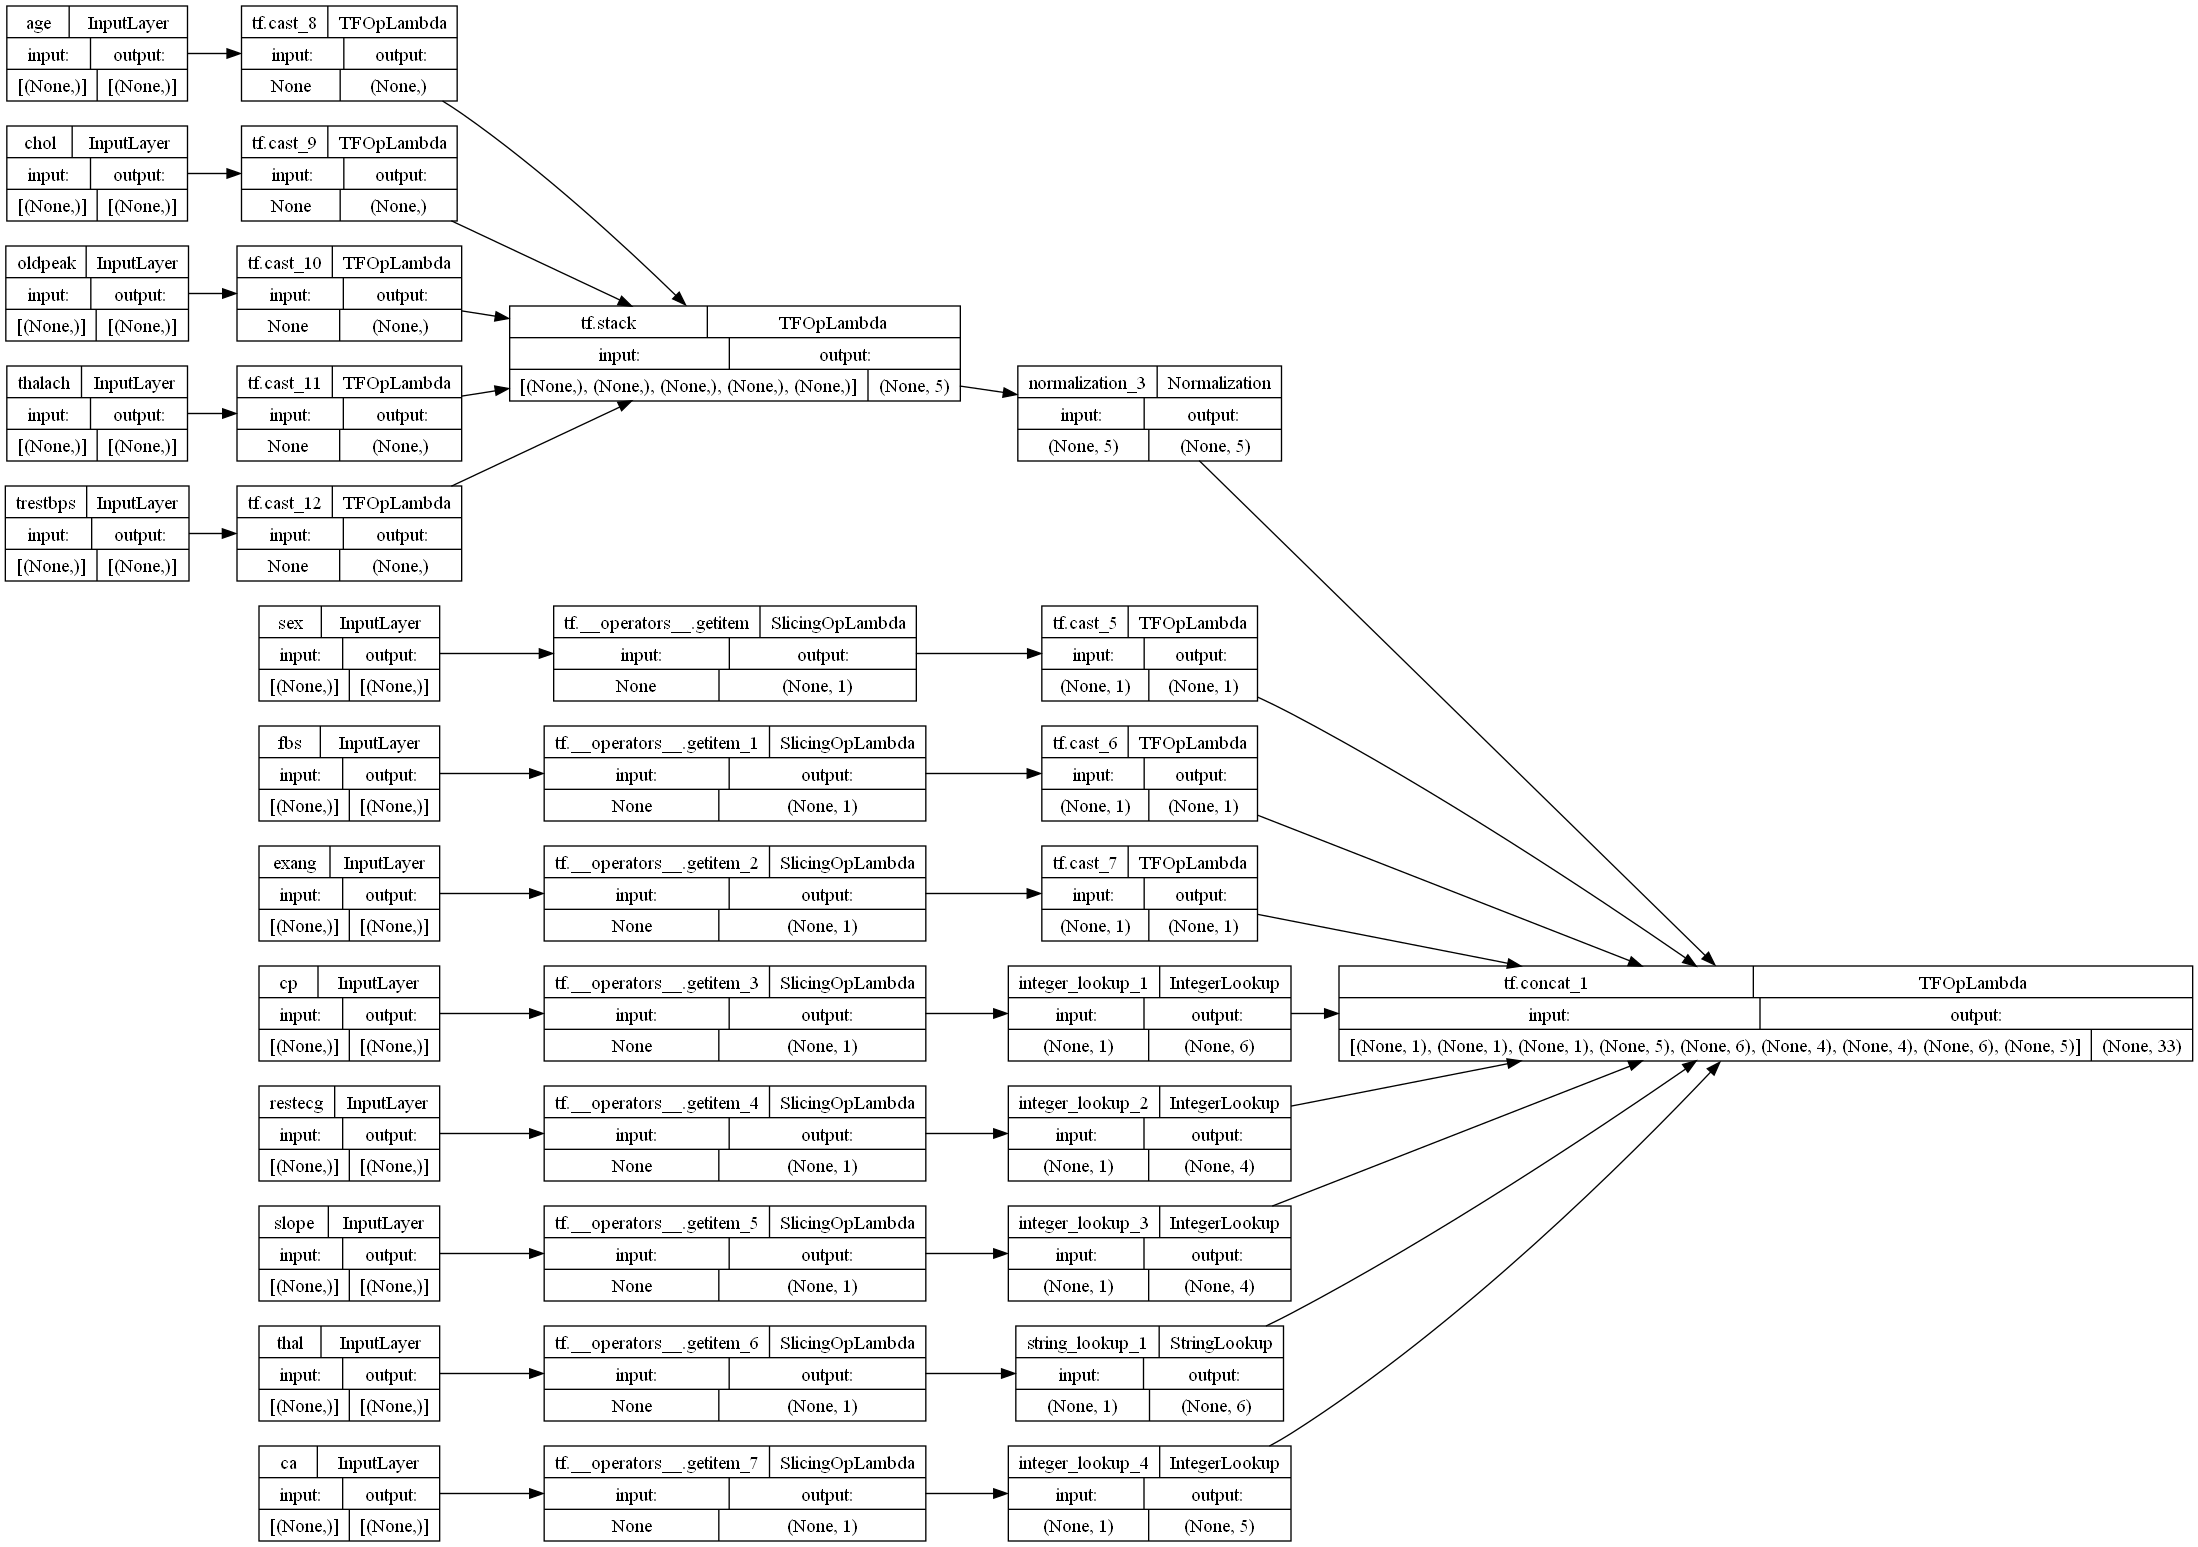

In [43]:
tf.keras.utils.plot_model(preprocessor, rankdir="LR", show_shapes=True)

To test the preprocessor, use the <a href="https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.iloc.html" class="external">DataFrame.iloc</a> accessor to slice the first example from the DataFrame. Then convert it to a dictionary and pass the dictionary to the preprocessor. The result is a single vector containing the binary features, normalized numeric features and the one-hot categorical features, in that order:

In [44]:
preprocessor(dict(df.iloc[:1]))

<tf.Tensor: shape=(1, 33), dtype=float32, numpy=
array([[ 1.        ,  1.        ,  0.        ,  0.93383914, -0.26008666,
         1.0680453 ,  0.03480718,  0.74578077,  0.        ,  0.        ,
         1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
         1.        ,  0.        ,  0.        ,  0.        ,  1.        ,
         0.        ,  0.        ,  0.        ]], dtype=float32)>

### Create and train a model

Now build the main body of the model. Use the same configuration as in the previous example: A couple of `Dense` rectified-linear layers and a `Dense(1)` output layer for the classification.

In [45]:
body = tf.keras.Sequential([
  tf.keras.layers.Dense(10, activation='relu'),
  tf.keras.layers.Dense(10, activation='relu'),
  tf.keras.layers.Dense(1)
])

Now put the two pieces together using the Keras functional API.

In [46]:
inputs

{'age': <KerasTensor: shape=(None,) dtype=float32 (created by layer 'age')>,
 'sex': <KerasTensor: shape=(None,) dtype=int64 (created by layer 'sex')>,
 'cp': <KerasTensor: shape=(None,) dtype=int64 (created by layer 'cp')>,
 'trestbps': <KerasTensor: shape=(None,) dtype=float32 (created by layer 'trestbps')>,
 'chol': <KerasTensor: shape=(None,) dtype=float32 (created by layer 'chol')>,
 'fbs': <KerasTensor: shape=(None,) dtype=int64 (created by layer 'fbs')>,
 'restecg': <KerasTensor: shape=(None,) dtype=int64 (created by layer 'restecg')>,
 'thalach': <KerasTensor: shape=(None,) dtype=float32 (created by layer 'thalach')>,
 'exang': <KerasTensor: shape=(None,) dtype=int64 (created by layer 'exang')>,
 'oldpeak': <KerasTensor: shape=(None,) dtype=float32 (created by layer 'oldpeak')>,
 'slope': <KerasTensor: shape=(None,) dtype=int64 (created by layer 'slope')>,
 'ca': <KerasTensor: shape=(None,) dtype=int64 (created by layer 'ca')>,
 'thal': <KerasTensor: shape=(None,) dtype=string 

In [47]:
x = preprocessor(inputs)
x

<KerasTensor: shape=(None, 33) dtype=float32 (created by layer 'model_1')>

In [48]:
result = body(x)
result

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'sequential_3')>

In [49]:
model = tf.keras.Model(inputs, result)

model.compile(optimizer='adam',
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=['accuracy'])

This model expects a dictionary of inputs. The simplest way to pass it the data is to convert the DataFrame to a dict and pass that dict as the `x` argument to `Model.fit`:

In [50]:
history = model.fit(dict(df), target, epochs=5, batch_size=BATCH_SIZE)

Epoch 1/5


152/152 [==============================] - 1s 782us/step - loss: 0.6229 - accuracy: 0.7195
Epoch 2/5
152/152 [==============================] - 0s 900us/step - loss: 0.4641 - accuracy: 0.7426
Epoch 3/5
152/152 [==============================] - 0s 734us/step - loss: 0.3806 - accuracy: 0.7723
Epoch 4/5
152/152 [==============================] - 0s 817us/step - loss: 0.3393 - accuracy: 0.8020
Epoch 5/5
152/152 [==============================] - 0s 824us/step - loss: 0.3104 - accuracy: 0.8284


Using `tf.data` works as well:

In [51]:
ds = tf.data.Dataset.from_tensor_slices((
    dict(df),
    target
))

ds = ds.batch(BATCH_SIZE)

In [52]:
import pprint

for x, y in ds.take(1):
  pprint.pprint(x)
  print()
  print(y)

{'age': <tf.Tensor: shape=(2,), dtype=int64, numpy=array([63, 67], dtype=int64)>,
 'ca': <tf.Tensor: shape=(2,), dtype=int64, numpy=array([0, 3], dtype=int64)>,
 'chol': <tf.Tensor: shape=(2,), dtype=int64, numpy=array([233, 286], dtype=int64)>,
 'cp': <tf.Tensor: shape=(2,), dtype=int64, numpy=array([1, 4], dtype=int64)>,
 'exang': <tf.Tensor: shape=(2,), dtype=int64, numpy=array([0, 1], dtype=int64)>,
 'fbs': <tf.Tensor: shape=(2,), dtype=int64, numpy=array([1, 0], dtype=int64)>,
 'oldpeak': <tf.Tensor: shape=(2,), dtype=float64, numpy=array([2.3, 1.5])>,
 'restecg': <tf.Tensor: shape=(2,), dtype=int64, numpy=array([2, 2], dtype=int64)>,
 'sex': <tf.Tensor: shape=(2,), dtype=int64, numpy=array([1, 1], dtype=int64)>,
 'slope': <tf.Tensor: shape=(2,), dtype=int64, numpy=array([3, 2], dtype=int64)>,
 'thal': <tf.Tensor: shape=(2,), dtype=string, numpy=array([b'fixed', b'normal'], dtype=object)>,
 'thalach': <tf.Tensor: shape=(2,), dtype=int64, numpy=array([150, 108], dtype=int64)>,
 'tr

In [53]:
history = model.fit(ds, epochs=5)

Epoch 1/5
152/152 [==============================] - 0s 865us/step - loss: 0.2947 - accuracy: 0.8416
Epoch 2/5
152/152 [==============================] - 0s 828us/step - loss: 0.2835 - accuracy: 0.8581
Epoch 3/5
152/152 [==============================] - 0s 895us/step - loss: 0.2751 - accuracy: 0.8680
Epoch 4/5
152/152 [==============================] - 0s 782us/step - loss: 0.2683 - accuracy: 0.8614
Epoch 5/5
152/152 [==============================] - 0s 900us/step - loss: 0.2626 - accuracy: 0.8647
